In [1]:
import pandas as pd
import string, glob, os
from tqdm import tqdm

In [76]:
# Load the genderize data
genderize = pd.read_csv("../source_data/genderizer_collected.csv").set_index('name')
genderize.head()
known_names = set(genderize.index.values)

In [3]:
def parse_df(df):
    lets = set(string.ascii_letters+"- .")
    data = []
    for f, names in tqdm(zip(df.index, df.Names), total=len(df)):
        if type(names) == float:
            continue
            
        for name in names.split(';'):
            if not all([a in lets for a in name]):
                continue
            if not name.strip():
                continue
            
            first_name = name.split().pop()
            if first_name not in known_names:
                continue

            x = genderize.loc[first_name]
            item = {"filename":f}
            item["first_name"] = first_name
            item["gcount"] = x["count"]
            item["ggender"] = x["gender"]
            item["gprobability"] = x["probability"]

            data.append(item)

    data = pd.DataFrame(data).dropna()
    return data

In [4]:
# Load the names from PMC ack
df = pd.read_csv("../parsed_data/Extracted Names A-B.csv", nrows=20,usecols=["filename","Names"]).set_index("filename")
df["Names"].fillna("",inplace=True)

data = parse_df(df)
data.head()

100%|██████████| 20/20 [00:00<00:00, 1074.26it/s]


,filename,first_name,gcount,ggender,gprobability
0,20_Century_Br_Hist/PMC4804230.nxml,Thomson,7.0,male,1.00
1,20_Century_Br_Hist/PMC5905639.nxml,Thomson,7.0,male,1.00
2,3D_Print_Med/PMC5954789.nxml,Wong,215.0,female,0.50
3,3D_Print_Med/PMC5954789.nxml,Lee,2089.0,male,0.75
4,3D_Print_Med/PMC5954790.nxml,Smith,28.0,male,0.68


In [5]:
F_CSV = glob.glob("../parsed_data/Extracted Names*.csv")
save_dest = "parsed_gender_data"
os.system(f'mkdir -p {save_dest}')

for f in F_CSV:
    df = pd.read_csv(f, 
                     nrows=10**20,
                     usecols=["filename","Names"]).set_index("filename")
    df["Names"].fillna("",inplace=True)
    data = parse_df(df)
    
    f_csv = os.path.join(save_dest, os.path.basename(f))
    print(data.head())
    data.to_csv(f_csv)
    

100%|██████████| 464167/464167 [00:30<00:00, 15238.62it/s]


                       filename first_name  gcount ggender  gprobability
0       CALPHAD/PMC4270480.nxml    Ganesan     4.0    male          1.00
1  CASE_(Phila)/PMC6058275.nxml      Singh    19.0    male          0.79
2  CASE_(Phila)/PMC6058275.nxml      Cohen     6.0  female          0.50
3  CASE_(Phila)/PMC6058300.nxml     Miller    31.0    male          0.84
4  CASE_(Phila)/PMC6058953.nxml  Takahashi     2.0  female          1.00


100%|██████████| 653444/653444 [00:47<00:00, 13650.77it/s]


                   filename first_name  gcount ggender  gprobability
0  IBRO_Rep/PMC6084867.nxml       Maya   427.0  female          0.97
1  IBRO_Rep/PMC6084822.nxml    Carlson     1.0    male          1.00
2  IBRO_Rep/PMC5289700.nxml     Hassan   612.0    male          0.99
3  IBRO_Rep/PMC5289700.nxml       Wang    54.0    male          0.74
4  IBRO_Rep/PMC6084913.nxml     Suzuki     2.0  female          0.50


100%|██████████| 610080/610080 [01:06<00:00, 9190.47it/s]


                       filename first_name  gcount ggender  gprobability
0  Obere_Extrem/PMC5579070.nxml    Chapman    10.0    male          1.00
1    Obes_Facts/PMC5644672.nxml       Jess  1010.0  female          0.91
4    Obes_Facts/PMC5644860.nxml      Roman   449.0    male          1.00
5    Obes_Facts/PMC5644847.nxml       Dick   163.0    male          0.99
6    Obes_Facts/PMC5644847.nxml       Reha     4.0    male          1.00


100%|██████████| 378845/378845 [00:36<00:00, 10272.19it/s]


                             filename first_name  gcount ggender  gprobability
0  20_Century_Br_Hist/PMC4804230.nxml    Thomson     7.0    male          1.00
1  20_Century_Br_Hist/PMC5905639.nxml    Thomson     7.0    male          1.00
2        3D_Print_Med/PMC5954789.nxml       Wong   215.0  female          0.50
3        3D_Print_Med/PMC5954789.nxml        Lee  2089.0    male          0.75
4        3D_Print_Med/PMC5954790.nxml      Smith    28.0    male          0.68


In [6]:
# Load all the results for a plotting
F_CSV = glob.glob("parsed_gender_data/*.csv")
df = pd.concat([pd.read_csv(f, nrows=10**20) for f in F_CSV]).reset_index()
df.tail()


,index,Unnamed: 0,filename,first_name,gcount,ggender,gprobability
784245,110599,119917,Burns_Trauma/PMC6040609.nxml,Lloyd,159.0,male,0.99
784246,110600,119918,Burns_Trauma/PMC6040609.nxml,James,6359.0,male,0.99
784247,110601,119919,Burns_Trauma/PMC6040609.nxml,Nelson,609.0,male,0.99
784248,110602,119920,Bus_Soc/PMC4944588.nxml,Wilson,544.0,male,0.99
784249,110603,119921,Bus_Soc/PMC4944588.nxml,Kennedy,37.0,male,0.57


In [7]:
df["is_female"] = df.ggender=="female"
print("Fraction of people on an ack that are female:", df.is_female.mean())

Fraction of people on an ack that are female: 0.2293018807778132


In [8]:
x = df.groupby("filename")["is_female"].mean()
(x.median(), x.mean())

(0.0, 0.2298866592426478)

In [9]:
info = pd.read_csv("../source_data/PMC_info-iSearch_-_Publications-export_2018-09-04-20-53-47.csv",
                   nrows=10**20, usecols = ["PMCID", "Author First Name"])
info = info.rename(columns={"Author First Name":"Names","PMCID":"filename"})
info.head()

,filename,Names
0,PMC5897966,Linda A;Susan;Ravi;John
1,PMC5897967,Guillaume;Carolyn
2,PMC5897968,Jeffrey;Dondrae J;Gregory W;Gregory G
3,PMC5897969,Jeffrey D;Paul J;David C;Faisal;Marta B;Aamir ...
4,PMC5897970,Andrew W;Kofi M;Caspar M;Julie R;Ernest Victor...


In [10]:
backup = info.copy()

In [11]:
info["PMCID"] = info.filename.str[3:]
idx = info.PMCID.str.isnumeric()
info = info[idx]
info["PMCID"] = info.PMCID.astype(int)

In [12]:
df.filename = df.filename.astype(str)
df["PMCID"] = df.filename.astype(str).str.split('/').str[-1].str.split('.').str[0].str[3:]

In [13]:
idx = df.PMCID.str.isnumeric()
df = df[idx]
df["PMCID"] = df.PMCID.astype(int)

In [14]:
df.head().PMCID, info.head().PMCID

(0    4270480
 1    6058275
 2    6058275
 3    6058300
 4    6058953
 Name: PMCID, dtype: int64, 0    5897966
 1    5897967
 2    5897968
 3    5897969
 4    5897970
 Name: PMCID, dtype: int64)

In [15]:
df = df.set_index("PMCID")
info = info.set_index("PMCID")

In [16]:
matching = df.index.isin(info.index)
matching.mean(), matching.sum()

(0.9963722284845734, 781383)

In [17]:
info_subset = info.loc[df[matching].index]

In [18]:
pubgender = parse_df(info_subset)
pubgender.tail()

100%|██████████| 781452/781452 [15:13<00:00, 855.17it/s]


,filename,first_name,gcount,ggender,gprobability
4016254,6040608,Sundas,4.0,female,1.0
4016255,6040608,Adnan,267.0,male,1.0
4016256,6040608,Akhtar,8.0,male,1.0
4016257,6040608,Sundas,4.0,female,1.0
4016258,6040608,Adnan,267.0,male,1.0


In [19]:
pubgender = pubgender.set_index("filename")

In [20]:
df.head(), pubgender.head()

(         index  Unnamed: 0                      filename first_name  gcount  \
 PMCID                                                                         
 4270480      0           0       CALPHAD/PMC4270480.nxml    Ganesan     4.0   
 6058275      1           1  CASE_(Phila)/PMC6058275.nxml      Singh    19.0   
 6058275      2           2  CASE_(Phila)/PMC6058275.nxml      Cohen     6.0   
 6058300      3           3  CASE_(Phila)/PMC6058300.nxml     Miller    31.0   
 6058953      4           4  CASE_(Phila)/PMC6058953.nxml  Takahashi     2.0   
 
         ggender  gprobability  is_female  
 PMCID                                     
 4270480    male          1.00      False  
 6058275    male          0.79      False  
 6058275  female          0.50       True  
 6058300    male          0.84      False  
 6058953  female          1.00       True  ,
          first_name  gcount ggender  gprobability
 filename                                         
 4270480      Simona   503.

In [87]:
pubgender["is_female"] = pubgender.ggender=="female"
authors = pubgender.reset_index().groupby("filename")["is_female"].mean()
print("Fraction of female authors publications", authors.mean())

Fraction of female authors publications 0.42397238128455006


In [107]:
ack = df.reset_index().groupby("PMCID")["is_female"].mean()
ack = pd.DataFrame(ack)
ack["is_female_authors"] = authors
ack = ack.dropna(subset=["is_female_authors"])
print("Number of total acks that we have information for", len(ack))

Number of total acks that we have information for 312237


In [108]:
ack.describe()

,is_female,is_female_authors
count,312237.000000,312237.000000
mean,0.233161,0.423972
std,0.366778,0.333895
min,0.000000,0.000000
25%,0.000000,0.083333
50%,0.000000,0.416667
75%,0.500000,0.666667
max,1.000000,1.000000


In [109]:
import pylab as plt
import seaborn as sns

Text(0.5,1,'Difference between average gender of authors vs acknowledgments')

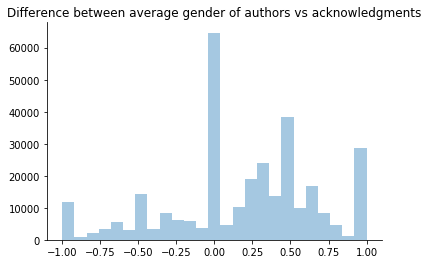

In [110]:
sns.distplot(ack.is_female_authors - ack.is_female,bins=25,kde=False)
sns.despine()
plt.title("Difference between average gender of authors vs acknowledgments")

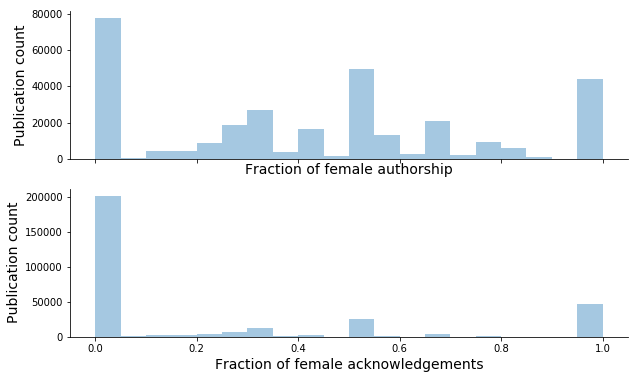

In [133]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
axes = axes.ravel()

sns.distplot(ack.is_female,
             label="Acknowledgments average gender",norm_hist=False,kde=False,bins=20,ax=axes[1])
sns.distplot(ack.is_female_authors, label="Author average gender",norm_hist=False,kde=False,bins=20,ax=axes[0])
axes[0].set_xlabel("Fraction of female authorship", fontsize=14)
axes[1].set_xlabel("Fraction of female acknowledgements", fontsize=14)

axes[0].set_ylabel("Publication count", fontsize=14)
axes[1].set_ylabel("Publication count", fontsize=14)


sns.despine()
plt.show()


In [118]:
print("Number of all-male ack", (ack.is_female == 0).sum())
print("Number of all-female ack", (ack.is_female == 1).sum())
singles = df[df.reset_index().groupby("PMCID").size()==1]
singles.is_female.mean(), singles.is_female_authors.mean()

Number of all-male ack 202150
Number of all-female ack 47105


/home/ubuntu/.pyenv/versions/3.6.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


AttributeError: 'DataFrame' object has no attribute 'is_female_authors'

In [95]:
(202150+47105)/float(len(ack))

0.7982878390453405

In [80]:
ack_counts = pubgender.reset_index().groupby("filename").size()
pub_counts = info_subset.reset_index().groupby("PMCID").size()

print("Median acks/per", ack_counts.median())
print("Median authors/per", pub_counts.median())

ack_counts = ack_counts[ack_counts<20]
pub_counts = pub_counts[pub_counts<20]
#ack_counts
#pub_counts.sort_values(ascending=False).head(), ack_counts.sort_values(ascending=False).head()

Median acks/per 5.0
Median authors/per 1.0


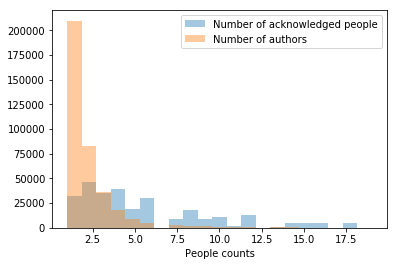

In [82]:
sns.distplot(ack_counts.values, label="Number of acknowledged people",norm_hist=False,kde=False,bins=21)
sns.distplot(pub_counts.values, label="Number of authors",norm_hist=False,kde=False,bins=21)
plt.legend()
plt.xlabel("People counts")
plt.show()